In [2]:
import numpy as np
import pandas as pd

RAW_CSV = "E:/DL Project/data/lob.csv"

df = pd.read_csv(RAW_CSV, low_memory=False)
print("Initial shape:", df.shape)
print("First 10 cols:", df.columns.tolist()[:10])

# helper: cope with int/str column labels
def colname(x):
    """Return the actual column key in df for logical index x (0-based),
       handling both int and string labels."""
    if x in df.columns:
        return x
    s = str(x)
    if s in df.columns:
        return s
    # fallback: position
    return df.columns[x]

# timestamps
unix_ts_col   = colname(0)
human_ts_col  = colname(1)

# 10 bid & 10 ask levels, price/size alternating
bid_price_positions = list(range(2, 22, 2))   # 2,4,...,20
bid_size_positions  = list(range(3, 23, 2))   # 3,5,...,21
ask_price_positions = list(range(22, 42, 2))  # 22,24,...,40
ask_size_positions  = list(range(23, 43, 2))  # 23,25,...,41

bid_price_cols = [colname(p) for p in bid_price_positions]
bid_size_cols  = [colname(p) for p in bid_size_positions]
ask_price_cols = [colname(p) for p in ask_price_positions]
ask_size_cols  = [colname(p) for p in ask_size_positions]

print("unix_ts_col:", unix_ts_col)
print("human_ts_col:", human_ts_col)
print("bid_price_cols:", bid_price_cols[:10])
print("bid_size_cols :", bid_size_cols[:10])
print("ask_price_cols:", ask_price_cols[:10])
print("ask_size_cols :", ask_size_cols[:10])


Initial shape: (3730870, 43)
First 10 cols: ['Unnamed: 0', '0', '1', '2', '3', '4', '5', '6', '7', '8']
unix_ts_col: 0
human_ts_col: 1
bid_price_cols: ['2', '4', '6', '8', '10', '12', '14', '16', '18', '20']
bid_size_cols : ['3', '5', '7', '9', '11', '13', '15', '17', '19', '21']
ask_price_cols: ['22', '24', '26', '28', '30', '32', '34', '36', '38', '40']
ask_size_cols : ['23', '25', '27', '29', '31', '33', '35', '37', '39', '41']


In [7]:
# parse unix microseconds timestamp -> datetime
try:
    df['timestamp'] = pd.to_datetime(df[unix_ts_col], unit='ms', utc=True)
except Exception as e:
    print("Failed unix ts parse, trying human-readable:", e)
    df['timestamp'] = pd.to_datetime(df[human_ts_col], utc=True, infer_datetime_format=True)

# sort by time
df = df.sort_values('timestamp').reset_index(drop=True)

# coerce all LOB cols to numeric
for c in bid_price_cols + bid_size_cols + ask_price_cols + ask_size_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')

# drop rows where best bid / ask are missing
df = df.dropna(subset=[bid_price_cols[0], ask_price_cols[0]]).reset_index(drop=True)
print("After basic cleaning:", df.shape)
print(df[['timestamp', bid_price_cols[0], ask_price_cols[0]]].head())


After basic cleaning: (3730870, 44)
                         timestamp        2       22
0 2023-01-09 22:17:40.926000+00:00  17181.6  17181.7
1 2023-01-09 22:17:41.177000+00:00  17181.6  17181.7
2 2023-01-09 22:17:41.427000+00:00  17181.6  17181.7
3 2023-01-09 22:17:41.678000+00:00  17181.6  17181.7
4 2023-01-09 22:17:41.928000+00:00  17181.6  17181.7


In [8]:
print("Shape after cleaning:", df.shape)
print("\nSome key columns:")
display(
    df[['timestamp',
        bid_price_cols[0], bid_size_cols[0],
        ask_price_cols[0], ask_size_cols[0]
       ]].head(10)
)


Shape after cleaning: (3730870, 44)

Some key columns:


,timestamp,2,3,22,23
0,2023-01-09 22:17:40.926000+00:00,17181.6,23.371,17181.7,7.474
1,2023-01-09 22:17:41.177000+00:00,17181.6,24.232,17181.7,7.088
2,2023-01-09 22:17:41.427000+00:00,17181.6,24.403,17181.7,7.089
3,2023-01-09 22:17:41.678000+00:00,17181.6,24.874,17181.7,6.540
4,2023-01-09 22:17:41.928000+00:00,17181.6,24.403,17181.7,6.069
5,2023-01-09 22:17:42.178000+00:00,17181.6,24.403,17181.7,7.272
6,2023-01-09 22:17:42.428000+00:00,17181.6,24.376,17181.7,6.364
7,2023-01-09 22:17:42.679000+00:00,17181.6,24.376,17181.7,5.570
8,2023-01-09 22:17:42.930000+00:00,17181.6,24.376,17181.7,5.570
9,2023-01-09 22:17:43.181000+00:00,17181.6,24.376,17181.7,5.548


In [9]:
def add_basic_lob_features(df,
                           bid_price_cols, bid_size_cols,
                           ask_price_cols, ask_size_cols):
    df = df.copy()
    n_levels = len(bid_price_cols)

    # best bid/ask (level 1)
    df['best_bid'] = df[bid_price_cols[0]]
    df['best_ask'] = df[ask_price_cols[0]]
    df['mid_price'] = (df['best_bid'] + df['best_ask']) / 2.0
    df['spread'] = df['best_ask'] - df['best_bid']

    # per-side depth (sum of sizes)
    df['bid_depth'] = df[bid_size_cols].sum(axis=1)
    df['ask_depth'] = df[ask_size_cols].sum(axis=1)

    # order book imbalance (OBI)
    df['obi'] = (df['bid_depth'] - df['ask_depth']) / (df['bid_depth'] + df['ask_depth'] + 1e-9)

    # optional: level-wise depth columns (already are bid_size/ask_size; you can keep them)
    return df

df = add_basic_lob_features(df, bid_price_cols, bid_size_cols, ask_price_cols, ask_size_cols)

print(df[['timestamp', 'mid_price', 'spread', 'bid_depth', 'ask_depth', 'obi']].head())


                         timestamp  mid_price  spread  bid_depth  ask_depth  \
0 2023-01-09 22:17:40.926000+00:00   17181.65     0.1     40.495     31.670   
1 2023-01-09 22:17:41.177000+00:00   17181.65     0.1     41.304     29.138   
2 2023-01-09 22:17:41.427000+00:00   17181.65     0.1     41.475     29.838   
3 2023-01-09 22:17:41.678000+00:00   17181.65     0.1     41.935     30.882   
4 2023-01-09 22:17:41.928000+00:00   17181.65     0.1     41.498     30.278   

        obi  
0  0.122289  
1  0.172709  
2  0.163182  
3  0.151791  
4  0.156320  


In [11]:
from scipy.signal import savgol_filter

def apply_savgol_smoothing(df, columns, window_length=11, polyorder=3, suffix="_sg"):
    df = df.copy()
    for col in columns:
        arr = df[col].astype(float).values
        if len(arr) < window_length:
            df[col + suffix] = arr
        else:
            df[col + suffix] = savgol_filter(arr, window_length, polyorder)
    return df

smooth_cols = ['mid_price', 'spread', 'bid_depth', 'ask_depth', 'obi']
df = apply_savgol_smoothing(df, smooth_cols, window_length=11, polyorder=3)

df[['mid_price', 'mid_price_sg', 'obi', 'obi_sg']].head()


,mid_price,mid_price_sg,obi,obi_sg
0,17181.65,17181.65,0.122289,0.146895
1,17181.65,17181.65,0.172709,0.144944
2,17181.65,17181.65,0.163182,0.145294
3,17181.65,17181.65,0.151791,0.148071
4,17181.65,17181.65,0.156320,0.153398


In [12]:
def make_returns(df, horizon, price_col='mid_price'):
    prices = df[price_col].values
    future = np.roll(prices, -horizon)
    r = (future - prices) / (prices + 1e-12)
    r[-horizon:] = np.nan   # invalid tail
    return pd.Series(r, index=df.index, name=f"ret_{horizon}")

def make_labels(df, ret_col, eps=2e-5, ternary=False):
    r = df[ret_col]
    if ternary:
        labels = np.where(r > eps,  1,
                  np.where(r < -eps, -1, 0))
    else:
        labels = np.where(r > eps,  1,
                  np.where(r < -eps,  0, np.nan))   # nan = ignore tiny moves
    return pd.Series(labels, index=df.index)

# choose horizon and epsilon
HORIZON_STEPS = 20    # example (tune depending on your sampling)
EPS = 2e-5            # threshold for "meaningful" move ~ 2 bps

df['ret'] = make_returns(df, HORIZON_STEPS, price_col='mid_price')
df['label_bin']   = make_labels(df, 'ret', eps=EPS, ternary=False)
df['label_tern']  = make_labels(df, 'ret', eps=EPS, ternary=True)

print("Label_bin counts (including NaN):")
print(df['label_bin'].value_counts(dropna=False))
print("\nLabel_tern distribution:")
print(df['label_tern'].value_counts(normalize=True))

# drop rows that cannot be used (NaN returns or NaN binary label)
df_clean = df.dropna(subset=['ret', 'label_bin']).reset_index(drop=True)
print("After cleaning:", df_clean.shape)


Label_bin counts (including NaN):
label_bin
NaN    1409252
0.0    1164323
1.0    1157295
Name: count, dtype: int64

Label_tern distribution:
label_tern
 0    0.377727
-1    0.312078
 1    0.310194
Name: proportion, dtype: float64
After cleaning: (2321618, 59)


In [13]:
from typing import Tuple

def build_sequences(df, feature_cols, label_col, window):
    data = df[feature_cols].values
    labels = df[label_col].values
    
    X, y = [], []
    for i in range(len(df) - window):
        X.append(data[i:i+window])
        y.append(labels[i+window-1])   # label at end of window
    
    X = np.array(X)    # (N, window, F)
    y = np.array(y)
    
    mask = ~np.isnan(y)
    return X[mask], y[mask]

# choose which features to use: SG versions as "better inputs"
feature_cols_sg = [
    'mid_price_sg', 'spread_sg', 'bid_depth_sg', 'ask_depth_sg', 'obi_sg'
]

WINDOW = 20  # context window length

X_sg, y_bin = build_sequences(df_clean, feature_cols_sg, 'label_bin', WINDOW)
print("X_sg shape:", X_sg.shape, "y_bin shape:", y_bin.shape)

# for simple models: flatten
X_sg_flat = X_sg.reshape(X_sg.shape[0], -1)


X_sg shape: (2321598, 20, 5) y_bin shape: (2321598,)


In [19]:
def time_based_split(X, y, train_frac=0.7, val_frac=0.15):
    N = len(X)
    train_end = int(N * train_frac)
    val_end   = int(N * (train_frac + val_frac))
    
    X_train, y_train = X[:train_end], y[:train_end]
    X_val,   y_val   = X[train_end:val_end], y[train_end:val_end]
    X_test,  y_test  = X[val_end:], y[val_end:]
    return X_train, y_train, X_val, y_val, X_test, y_test

X_tr_sg, y_tr_sg, X_val_sg, y_val_sg, X_te_sg, y_te_sg = time_based_split(X_sg_flat, y_bin)

print("Train:", X_tr_sg.shape, "Val:", X_val_sg.shape, "Test:", X_te_sg.shape)


Train: (1625118, 100) Val: (348240, 100) Test: (348240, 100)


In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# scale features for LR
scaler = StandardScaler()
X_tr_scaled = scaler.fit_transform(X_tr_sg)
X_val_scaled = scaler.transform(X_val_sg)
X_te_scaled = scaler.transform(X_te_sg)

clf_lr = LogisticRegression(
    max_iter=10000,
    class_weight='balanced',   # handles class imbalance
    n_jobs=-1
)
clf_lr.fit(X_tr_scaled, y_tr_sg)

y_pred_lr = clf_lr.predict(X_te_scaled)
print("Logistic Regression (SG features) – test report:")
print(classification_report(y_te_sg, y_pred_lr, digits=4))


Logistic Regression (SG features) – test report:
              precision    recall  f1-score   support

         0.0     0.7441    0.7487    0.7464    177010
         1.0     0.7386    0.7338    0.7362    171230

    accuracy                         0.7414    348240
   macro avg     0.7413    0.7413    0.7413    348240
weighted avg     0.7414    0.7414    0.7414    348240



In [21]:
def time_based_split(X, y, train_frac=0.7, val_frac=0.15):
    N = len(X)
    train_end = int(N * train_frac)
    val_end   = int(N * (train_frac + val_frac))
    
    X_train, y_train = X[:train_end], y[:train_end]
    X_val,   y_val   = X[train_end:val_end], y[train_end:val_end]
    X_test,  y_test  = X[val_end:], y[val_end:]
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = time_based_split(X_sg_flat, y_bin)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)


Train: (1625118, 100) Val: (348240, 100) Test: (348240, 100)


In [30]:
FAST_STEPS  = 25500
VAL_STEPS   = 5400
BATCH_SIZE  = 64

train_fast_size = FAST_STEPS * BATCH_SIZE      # 1200 * 64 = 76800
val_fast_size   = VAL_STEPS * BATCH_SIZE       # 300 * 64  = 19200

X_train_fast = X_train[:train_fast_size]
y_train_fast = y_train[:train_fast_size]

X_val_fast   = X_val[:val_fast_size]
y_val_fast   = y_val[:val_fast_size]

print("Fast train:", X_train_fast.shape, "Fast val:", X_val_fast.shape)


Fast train: (1625118, 100) Fast val: (345600, 100)


In [31]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

clf_xgb = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    n_jobs=-1,
    tree_method='hist'
)

clf_xgb.fit(X_train_fast, y_train_fast)

y_pred = clf_xgb.predict(X_test)  # test still on FULL test set 🔥
print("XGBoost (SG features, fast train) – test report:")
print(classification_report(y_test, y_pred, digits=4))


XGBoost (SG features, fast train) – test report:
              precision    recall  f1-score   support

         0.0     0.7523    0.7577    0.7550    177010
         1.0     0.7476    0.7420    0.7448    171230

    accuracy                         0.7500    348240
   macro avg     0.7499    0.7499    0.7499    348240
weighted avg     0.7500    0.7500    0.7500    348240



In [32]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc,
    precision_recall_curve,
    accuracy_score,
    f1_score
)


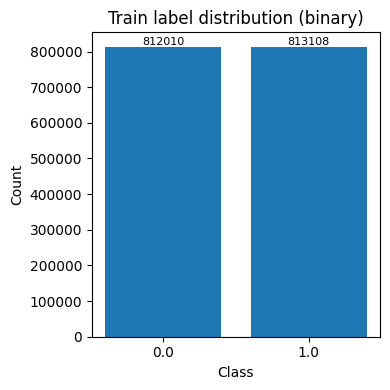

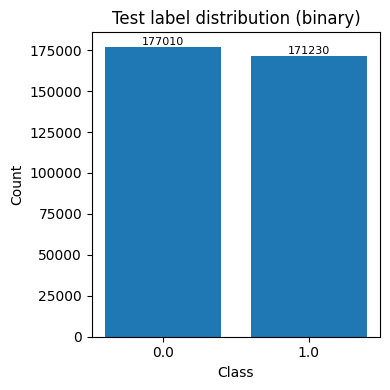

In [33]:
def plot_class_distribution(y, title="Class distribution"):
    unique, counts = np.unique(y, return_counts=True)
    plt.figure(figsize=(4,4))
    plt.bar(unique.astype(str), counts)
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.title(title)
    for i, c in enumerate(counts):
        plt.text(i, c, str(c), ha='center', va='bottom', fontsize=8)
    plt.tight_layout()
    plt.show()

plot_class_distribution(y_train, "Train label distribution (binary)")
plot_class_distribution(y_test, "Test label distribution (binary)")


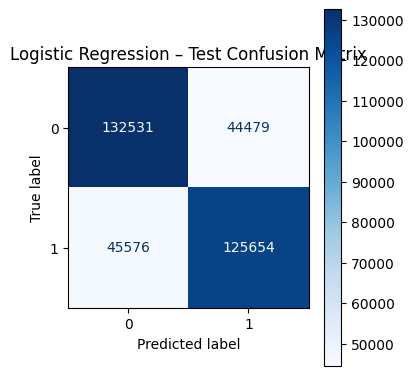

Logistic Regression – Test Confusion Matrix classification report:
              precision    recall  f1-score   support

         0.0     0.7441    0.7487    0.7464    177010
         1.0     0.7386    0.7338    0.7362    171230

    accuracy                         0.7414    348240
   macro avg     0.7413    0.7413    0.7413    348240
weighted avg     0.7414    0.7414    0.7414    348240



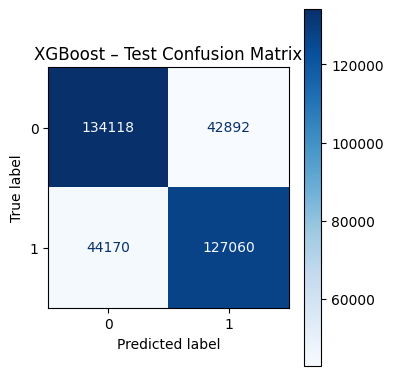

XGBoost – Test Confusion Matrix classification report:
              precision    recall  f1-score   support

         0.0     0.7523    0.7577    0.7550    177010
         1.0     0.7476    0.7420    0.7448    171230

    accuracy                         0.7500    348240
   macro avg     0.7499    0.7499    0.7499    348240
weighted avg     0.7500    0.7500    0.7500    348240



In [35]:
def plot_confusion(model, X, y_true, title):
    y_pred = model.predict(X)
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=[0,1])
    fig, ax = plt.subplots(figsize=(4,4))
    disp.plot(ax=ax, cmap="Blues", values_format='d')
    ax.set_title(title)
    plt.tight_layout()
    plt.show()
    print(title, "classification report:")
    print(classification_report(y_true, y_pred, digits=4))

# Logistic Regression
plot_confusion(clf_lr, X_te_scaled, y_te_sg, "Logistic Regression – Test Confusion Matrix")

# XGBoost
plot_confusion(clf_xgb, X_test, y_test, "XGBoost – Test Confusion Matrix")


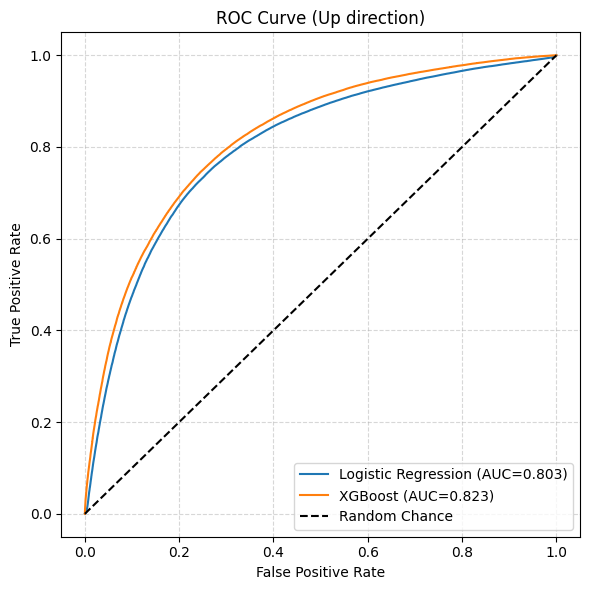

In [36]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

def plot_roc_lr_xgb(clf_lr, clf_xgb, X_lr, X_xgb, y_true):
    # predicted probabilities P(y=1)
    p_lr = clf_lr.predict_proba(X_lr)[:,1]
    p_xgb = clf_xgb.predict_proba(X_xgb)[:,1]

    fpr_lr, tpr_lr, _ = roc_curve(y_true, p_lr)
    fpr_xgb, tpr_xgb, _ = roc_curve(y_true, p_xgb)

    auc_lr  = auc(fpr_lr, tpr_lr)
    auc_xgb = auc(fpr_xgb, tpr_xgb)

    plt.figure(figsize=(6,6))
    plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC={auc_lr:.3f})")
    plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC={auc_xgb:.3f})")
    plt.plot([0,1], [0,1], 'k--', label='Random Chance')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (Up direction)')
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

# CALL:
plot_roc_lr_xgb(clf_lr, clf_xgb, X_te_scaled, X_test, y_test)


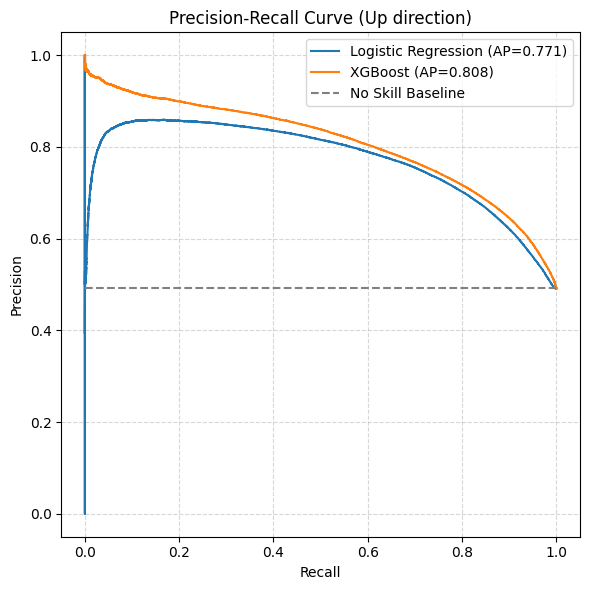

In [37]:
from sklearn.metrics import precision_recall_curve, average_precision_score

def plot_pr_lr_xgb(clf_lr, clf_xgb, X_lr, X_xgb, y_true):
    p_lr = clf_lr.predict_proba(X_lr)[:,1]
    p_xgb = clf_xgb.predict_proba(X_xgb)[:,1]

    prec_lr, rec_lr, _   = precision_recall_curve(y_true, p_lr)
    prec_xgb, rec_xgb, _ = precision_recall_curve(y_true, p_xgb)

    ap_lr  = average_precision_score(y_true, p_lr)
    ap_xgb = average_precision_score(y_true, p_xgb)

    plt.figure(figsize=(6,6))
    plt.plot(rec_lr,  prec_lr,  label=f"Logistic Regression (AP={ap_lr:.3f})")
    plt.plot(rec_xgb, prec_xgb, label=f"XGBoost (AP={ap_xgb:.3f})")

    baseline = np.sum(y_true)/len(y_true)
    plt.hlines(baseline, xmin=0, xmax=1, colors='gray',
               linestyles='dashed', label='No Skill Baseline')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve (Up direction)')
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

# CALL:
plot_pr_lr_xgb(clf_lr, clf_xgb, X_te_scaled, X_test, y_test)


In [38]:
import numpy as np
import pandas as pd

# 1) Rebuild sequences from df_clean to be sure we're synced
feature_cols_sg = ['mid_price_sg', 'spread_sg',
                   'bid_depth_sg', 'ask_depth_sg', 'obi_sg']
WINDOW = 20

def build_sequences(df, feature_cols, label_col, window):
    data = df[feature_cols].values
    labels = df[label_col].values
    X, y = [], []
    for i in range(len(df) - window):
        X.append(data[i:i+window])
        y.append(labels[i+window-1])
    X = np.array(X)
    y = np.array(y)
    mask = ~np.isnan(y)
    return X[mask], y[mask]

X_all, y_all = build_sequences(df_clean, feature_cols_sg, 'label_bin', WINDOW)
print("X_all shape:", X_all.shape, "y_all shape:", y_all.shape)


X_all shape: (2321598, 20, 5) y_all shape: (2321598,)


In [39]:
def time_split_3d(X, y, train_frac=0.7, val_frac=0.15):
    N = len(X)
    train_end = int(N * train_frac)
    val_end   = int(N * (train_frac + val_frac))
    X_train, y_train = X[:train_end], y[:train_end]
    X_val,   y_val   = X[train_end:val_end], y[train_end:val_end]
    X_test,  y_test  = X[val_end:], y[val_end:]
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = time_split_3d(X_all, y_all)

print("Train:", X_train.shape,
      "Val:",   X_val.shape,
      "Test:",  X_test.shape)


Train: (1625118, 20, 5) Val: (348240, 20, 5) Test: (348240, 20, 5)


In [40]:
import tensorflow as tf
from tensorflow.keras import layers, models

window = X_train.shape[1]
n_features = X_train.shape[2]

def build_deeplob_binary(window, n_features):
    inputs = layers.Input(shape=(window, n_features))

    # Block 1: temporal convs
    x = layers.Conv1D(32, kernel_size=3, padding='causal', activation='relu')(inputs)
    x = layers.Conv1D(32, kernel_size=3, padding='causal', activation='relu')(x)
    x = layers.MaxPooling1D(pool_size=2)(x)

    # Block 2: more convs
    x = layers.Conv1D(64, kernel_size=3, padding='causal', activation='relu')(x)
    x = layers.Conv1D(64, kernel_size=3, padding='causal', activation='relu')(x)
    x = layers.MaxPooling1D(pool_size=2)(x)

    # LSTM for temporal order
    x = layers.LSTM(64, return_sequences=False)(x)

    # Dense head
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)   # binary probability

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

model = build_deeplob_binary(window, n_features)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 20, 5)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 20, 32)         │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 20, 32)         │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 10, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,425 (232.13 KB)

 Trainable params: 59,425 (232.13 KB)

 Non-trainable params: 0 (0.00 B)

In [41]:
import tensorflow as tf
import numpy as np

# make sure labels are float32 for binary crossentropy
y_train_f = y_train.astype(np.float32)
y_val_f   = y_val.astype(np.float32)

BATCH_SIZE = 512   # you can lower to 256 if memory is an issue

# full datasets
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train_f))
val_ds   = tf.data.Dataset.from_tensor_slices((X_val,   y_val_f))

# shuffle + batch + repeat
train_ds = train_ds.shuffle(buffer_size=100_000).batch(BATCH_SIZE).repeat()
val_ds   = val_ds.batch(BATCH_SIZE).repeat()


In [44]:
import numpy as np

# 3D shapes: (N, window, features)
print("Shapes:", X_train.shape, X_val.shape, X_test.shape)

window = X_train.shape[1]
n_features = X_train.shape[2]

# Flatten train over time+batch to compute per-feature mean/std
flat_train = X_train.reshape(-1, n_features)
feat_mean = flat_train.mean(axis=0)
feat_std  = flat_train.std(axis=0) + 1e-8  # avoid divide-by-zero

print("Feature means:", feat_mean)
print("Feature stds :", feat_std)

def normalize_sequences(X, mean, std):
    return (X - mean) / std

X_train_n = normalize_sequences(X_train, feat_mean, feat_std)
X_val_n   = normalize_sequences(X_val,   feat_mean, feat_std)
X_test_n  = normalize_sequences(X_test,  feat_mean, feat_std)


Shapes: (1625118, 20, 5) (348240, 20, 5) (348240, 20, 5)
Feature means: [1.97718091e+04 1.11877977e-01 2.79986184e+01 2.73989558e+01
 6.65028116e-03]
Feature stds : [1.42058837e+03 2.60033688e-01 3.00961304e+01 2.93117295e+01
 5.67055364e-01]


In [45]:
import tensorflow as tf

# Labels as float32 for binary crossentropy
y_train_f = y_train.astype(np.float32)
y_val_f   = y_val.astype(np.float32)

BATCH_SIZE = 512  # drop to 256 if you hit memory issues

train_ds = tf.data.Dataset.from_tensor_slices((X_train_n, y_train_f))
val_ds   = tf.data.Dataset.from_tensor_slices((X_val_n,   y_val_f))

# Shuffle only training data
train_ds = train_ds.shuffle(buffer_size=100_000).batch(BATCH_SIZE).repeat()
val_ds   = val_ds.batch(BATCH_SIZE).repeat()

# Steps per epoch (fast but big enough)
FAST_STEPS = 2000   # 2000 * 512 ≈ 1,024,000 samples/epoch
VAL_STEPS  = 500    # 500 * 512  ≈ 256,000 val samples/epoch

print("Will use ~", FAST_STEPS * BATCH_SIZE, "train samples/epoch")
print("Will use ~", VAL_STEPS * BATCH_SIZE,  "val samples/epoch")


Will use ~ 1024000 train samples/epoch
Will use ~ 256000 val samples/epoch


In [47]:
from tensorflow.keras import layers, models

# If you don't have build_deeplob_binary defined anymore, uncomment & define:

# def build_deeplob_binary(window, n_features):
#     inputs = layers.Input(shape=(window, n_features))
#     x = layers.Conv1D(32, 3, padding='causal', activation='relu')(inputs)
#     x = layers.Conv1D(32, 3, padding='causal', activation='relu')(x)
#     x = layers.MaxPooling1D(pool_size=2)(x)
#     x = layers.Conv1D(64, 3, padding='causal', activation='relu')(x)
#     x = layers.Conv1D(64, 3, padding='causal', activation='relu')(x)
#     x = layers.MaxPooling1D(pool_size=2)(x)
#     x = layers.LSTM(64, return_sequences=False)(x)
#     x = layers.Dense(64, activation='relu')(x)
#     x = layers.Dropout(0.3)(x)
#     outputs = layers.Dense(1, activation='sigmoid')(x)
#     model = models.Model(inputs, outputs)
#     return model

model = build_deeplob_binary(window, n_features)
model.summary()

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc')
    ]
)

EPOCHS = 8

callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=3,
        min_lr=1e-5, verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=5,
        restore_best_weights=True, verbose=1
    )
]


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 20, 5)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 20, 32)         │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 20, 32)         │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 10, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 10, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,425 (232.13 KB)

 Trainable params: 59,425 (232.13 KB)

 Non-trainable params: 0 (0.00 B)

In [48]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    steps_per_epoch=FAST_STEPS,
    validation_steps=VAL_STEPS,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/8
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 34s 16ms/step - accuracy: 0.6874 - auc: 0.7540 - loss: 0.5875 - val_accuracy: 0.6867 - val_auc: 0.7584 - val_loss: 0.5845 - learning_rate: 5.0000e-04
Epoch 2/8
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 30s 15ms/step - accuracy: 0.7144 - auc: 0.7888 - loss: 0.5537 - val_accuracy: 0.6874 - val_auc: 0.7656 - val_loss: 0.5845 - learning_rate: 5.0000e-04
Epoch 3/8
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 30s 15ms/step - accuracy: 0.6798 - auc: 0.7453 - loss: 0.5954 - val_accuracy: 0.6977 - val_auc: 0.7774 - val_loss: 0.5664 - learning_rate: 5.0000e-04
Epoch 4/8
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 30s 15ms/step - accuracy: 0.7214 - auc: 0.8023 - loss: 0.5373 - val_accuracy: 0.6985 - val_auc: 0.7798 - val_loss: 0.5639 - learning_rate: 5.0000e-04
Epoch 5/8
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 31s 15ms/step - accuracy: 0.7234 - auc: 0.8026 - loss: 0.5377 - val_accuracy: 0.6984 - val_auc: 0.7825 - val_loss: 0.5652 - learning_rate: 5.0000e-04
Epoch 6/8
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 30s 

In [49]:
from sklearn.metrics import classification_report, accuracy_score, f1_score, roc_auc_score

# Use normalized X_test_n here
y_proba_test = model.predict(X_test_n, batch_size=1024).ravel()
y_pred_test  = (y_proba_test >= 0.5).astype(int)

print("DeepLOB (binary, normalized) – Test report:")
print(classification_report(y_test, y_pred_test, digits=4))

acc = accuracy_score(y_test, y_pred_test)
f1_macro = f1_score(y_test, y_pred_test, average='macro')
auc_roc = roc_auc_score(y_test, y_proba_test)

print(f"Accuracy: {acc:.4f}, F1_macro: {f1_macro:.4f}, ROC-AUC: {auc_roc:.4f}")


341/341 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
DeepLOB (binary, normalized) – Test report:
              precision    recall  f1-score   support

         0.0     0.7668    0.7549    0.7608    177010
         1.0     0.7507    0.7627    0.7566    171230

    accuracy                         0.7588    348240
   macro avg     0.7588    0.7588    0.7587    348240
weighted avg     0.7589    0.7588    0.7588    348240

Accuracy: 0.7588, F1_macro: 0.7587, ROC-AUC: 0.8412


341/341 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step


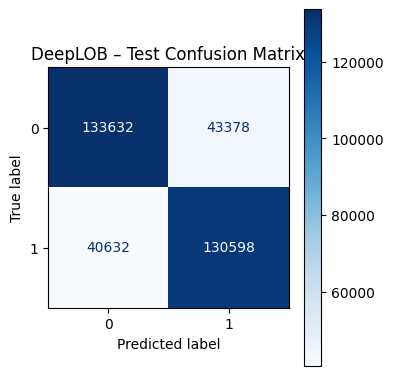

DeepLOB – classification report:
              precision    recall  f1-score   support

         0.0     0.7668    0.7549    0.7608    177010
         1.0     0.7507    0.7627    0.7566    171230

    accuracy                         0.7588    348240
   macro avg     0.7588    0.7588    0.7587    348240
weighted avg     0.7589    0.7588    0.7588    348240



In [51]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# ensure predictions
y_proba_test = model.predict(X_test_n, batch_size=1024).ravel()
y_pred_test  = (y_proba_test >= 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(cm, display_labels=[0,1])
fig, ax = plt.subplots(figsize=(4,4))
disp.plot(ax=ax, cmap="Blues", values_format='d')
ax.set_title("DeepLOB – Test Confusion Matrix")
plt.tight_layout()
plt.show()

print("DeepLOB – classification report:")
print(classification_report(y_test, y_pred_test, digits=4))


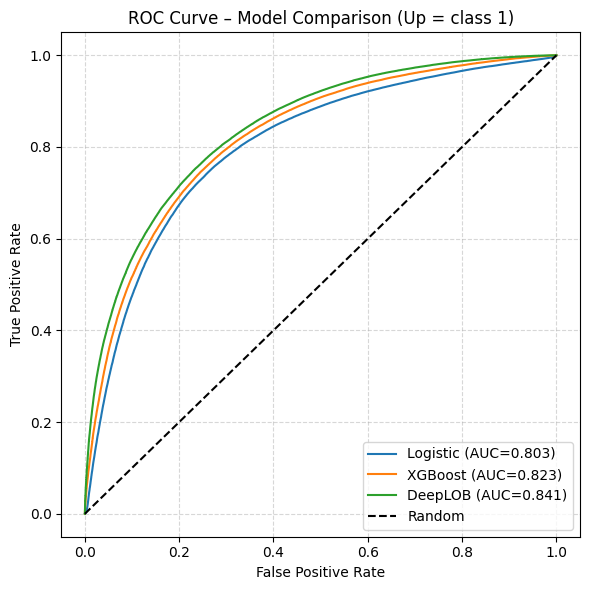

In [53]:
from sklearn.metrics import roc_curve, auc

# probs for class 1 from each model
p_lr   = clf_lr.predict_proba(X_te_scaled)[:, 1]   # scaled 2D
p_xgb  = clf_xgb.predict_proba(X_te_sg)[:, 1]      # flattened 2D used for XGB
p_deep = y_proba_test                              # from DeepLOB on X_test_n

fpr_lr,  tpr_lr,  _ = roc_curve(y_test, p_lr)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, p_xgb)
fpr_d,   tpr_d,   _ = roc_curve(y_test, p_deep)

auc_lr  = auc(fpr_lr,  tpr_lr)
auc_xgb = auc(fpr_xgb, tpr_xgb)
auc_d   = auc(fpr_d,   tpr_d)

plt.figure(figsize=(6,6))
plt.plot(fpr_lr,  tpr_lr,  label=f"Logistic (AUC={auc_lr:.3f})")
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC={auc_xgb:.3f})")
plt.plot(fpr_d,   tpr_d,   label=f"DeepLOB (AUC={auc_d:.3f})")
plt.plot([0,1], [0,1], 'k--', label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Model Comparison (Up = class 1)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


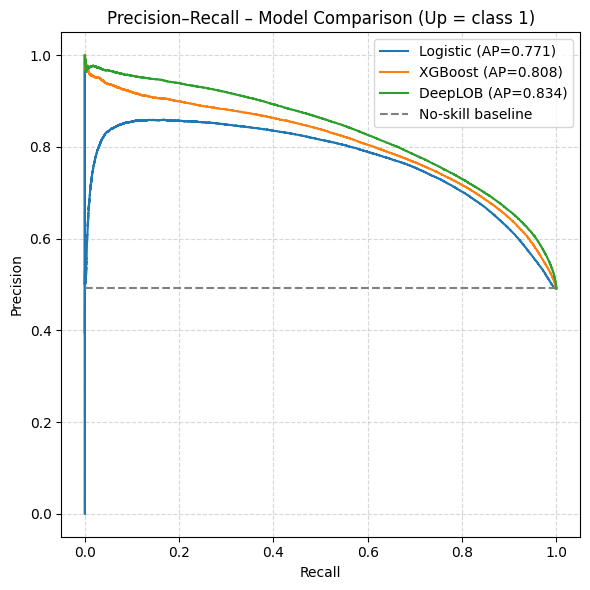

In [54]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import numpy as np

prec_lr,  rec_lr,  _ = precision_recall_curve(y_test, p_lr)
prec_xgb, rec_xgb, _ = precision_recall_curve(y_test, p_xgb)
prec_d,   rec_d,   _ = precision_recall_curve(y_test, p_deep)

ap_lr  = average_precision_score(y_test, p_lr)
ap_xgb = average_precision_score(y_test, p_xgb)
ap_d   = average_precision_score(y_test, p_deep)

baseline = np.sum(y_test) / len(y_test)

plt.figure(figsize=(6,6))
plt.plot(rec_lr,  prec_lr,  label=f"Logistic (AP={ap_lr:.3f})")
plt.plot(rec_xgb, prec_xgb, label=f"XGBoost (AP={ap_xgb:.3f})")
plt.plot(rec_d,   prec_d,   label=f"DeepLOB (AP={ap_d:.3f})")
plt.hlines(baseline, 0, 1, colors='gray', linestyles='--', label="No-skill baseline")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall – Model Comparison (Up = class 1)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


In [55]:
# 1) Build ternary sequences
feature_cols_sg = ['mid_price_sg', 'spread_sg',
                   'bid_depth_sg', 'ask_depth_sg', 'obi_sg']
WINDOW = 20

def build_sequences(df, feature_cols, label_col, window):
    data = df[feature_cols].values
    labels = df[label_col].values
    X, y = [], []
    for i in range(len(df) - window):
        X.append(data[i:i+window])
        y.append(labels[i+window-1])
    X = np.array(X)
    y = np.array(y)
    mask = ~np.isnan(y)
    return X[mask], y[mask]

X_all_tern, y_all_tern_raw = build_sequences(df_clean, feature_cols_sg, 'label_tern', WINDOW)

print("Ternary raw labels:", np.unique(y_all_tern_raw, return_counts=True))

# map -1,0,1  →  0,1,2 for Keras
mapping = {-1:0, 0:1, 1:2}
y_all_tern = np.vectorize(mapping.get)(y_all_tern_raw)
print("After mapping:", np.unique(y_all_tern, return_counts=True))


Ternary raw labels: (array([-1,  1]), array([1164323, 1157275], dtype=int64))
After mapping: (array([0, 2]), array([1164323, 1157275], dtype=int64))


In [56]:
def time_split_3d(X, y, train_frac=0.7, val_frac=0.15):
    N = len(X)
    train_end = int(N * train_frac)
    val_end   = int(N * (train_frac + val_frac))
    X_train, y_train = X[:train_end], y[:train_end]
    X_val,   y_val   = X[train_end:val_end], y[train_end:val_end]
    X_test,  y_test  = X[val_end:], y[val_end:]
    return X_train, y_train, X_val, y_val, X_test, y_test

Xtr_t, ytr_t, Xval_t, yval_t, Xte_t, yte_t = time_split_3d(X_all_tern, y_all_tern)
print("Ternary shapes:", Xtr_t.shape, Xval_t.shape, Xte_t.shape)

# normalize features using train stats
n_features = Xtr_t.shape[2]
flat_train_t = Xtr_t.reshape(-1, n_features)
feat_mean_t = flat_train_t.mean(axis=0)
feat_std_t  = flat_train_t.std(axis=0) + 1e-8

def normalize_sequences(X, mean, std):
    return (X - mean) / std

Xtr_t_n = normalize_sequences(Xtr_t, feat_mean_t, feat_std_t)
Xval_t_n = normalize_sequences(Xval_t, feat_mean_t, feat_std_t)
Xte_t_n  = normalize_sequences(Xte_t,  feat_mean_t, feat_std_t)


Ternary shapes: (1625118, 20, 5) (348240, 20, 5) (348240, 20, 5)


In [57]:
import tensorflow as tf

ytr_t_i  = ytr_t.astype('int32')
yval_t_i = yval_t.astype('int32')

BATCH_SIZE = 512
FAST_STEPS = 1500
VAL_STEPS  = 500

train_ds_t = tf.data.Dataset.from_tensor_slices((Xtr_t_n,  ytr_t_i))
val_ds_t   = tf.data.Dataset.from_tensor_slices((Xval_t_n, yval_t_i))

train_ds_t = train_ds_t.shuffle(100_000).batch(BATCH_SIZE).repeat()
val_ds_t   = val_ds_t.batch(BATCH_SIZE).repeat()


In [58]:
from tensorflow.keras import layers, models

window = Xtr_t_n.shape[1]
n_features = Xtr_t_n.shape[2]
n_classes = 3

def build_deeplob_ternary(window, n_features, n_classes=3):
    inputs = layers.Input(shape=(window, n_features))
    x = layers.Conv1D(32, 3, padding='causal', activation='relu')(inputs)
    x = layers.Conv1D(32, 3, padding='causal', activation='relu')(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Conv1D(64, 3, padding='causal', activation='relu')(x)
    x = layers.Conv1D(64, 3, padding='causal', activation='relu')(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.LSTM(64, return_sequences=False)(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(n_classes, activation='softmax')(x)
    return models.Model(inputs, outputs)

model_tern = build_deeplob_ternary(window, n_features, n_classes)
model_tern.summary()

model_tern.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

callbacks_t = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=3,
        min_lr=1e-5, verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=5,
        restore_best_weights=True, verbose=1
    )
]


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 20, 5)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_12 (Conv1D)              │ (None, 20, 32)         │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 20, 32)         │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_14 (Conv1D)              │ (None, 10, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_15 (Conv1D)              │ (None, 10, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,555 (232.64 KB)

 Trainable params: 59,555 (232.64 KB)

 Non-trainable params: 0 (0.00 B)

In [59]:
EPOCHS = 8

history_t = model_tern.fit(
    train_ds_t,
    validation_data=val_ds_t,
    epochs=EPOCHS,
    steps_per_epoch=FAST_STEPS,
    validation_steps=VAL_STEPS,
    callbacks=callbacks_t,
    verbose=1
)


Epoch 1/8
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 26s 16ms/step - accuracy: 0.6958 - loss: 0.5838 - val_accuracy: 0.6766 - val_loss: 0.6010 - learning_rate: 5.0000e-04
Epoch 2/8
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - accuracy: 0.6706 - loss: 0.6081 - val_accuracy: 0.6910 - val_loss: 0.5753 - learning_rate: 5.0000e-04
Epoch 3/8
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 24s 16ms/step - accuracy: 0.7303 - loss: 0.5313 - val_accuracy: 0.6944 - val_loss: 0.5772 - learning_rate: 5.0000e-04
Epoch 4/8
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 23s 15ms/step - accuracy: 0.6759 - loss: 0.6000 - val_accuracy: 0.6991 - val_loss: 0.5634 - learning_rate: 5.0000e-04
Epoch 5/8
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 23s 15ms/step - accuracy: 0.7427 - loss: 0.5124 - val_accuracy: 0.6811 - val_loss: 0.5843 - learning_rate: 5.0000e-04
Epoch 6/8
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 23s 15ms/step - accuracy: 0.6800 - loss: 0.5942 - val_accuracy: 0.7023 - val_loss: 0.5658 - learning_rate: 5.0000e-04
Epoch 7/8
1497/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 13

In [64]:
import numpy as np

print("True labels in test (yte_t):", np.unique(yte_t, return_counts=True))
print("Pred labels from model (y_pred_t):", np.unique(y_pred_t, return_counts=True))


True labels in test (yte_t): (array([0, 2]), array([177010, 171230], dtype=int64))
Pred labels from model (y_pred_t): (array([0, 2], dtype=int64), array([178491, 169749], dtype=int64))


In [65]:
import numpy as np
import pandas as pd

WINDOW = 20               # same as before
HORIZON_STEPS = 20        # 5 seconds ahead if 250ms sampling
TERN_THRESHOLD = 1e-4     # 0.01% move

def make_ternary_labels(df, horizon=HORIZON_STEPS, threshold=TERN_THRESHOLD):
    mp = df['mid_price'].values
    mp_future = np.roll(mp, -horizon)
    ret = (mp_future - mp) / (mp + 1e-12)

    # mark last horizon points as invalid (no future)
    ret[-horizon:] = np.nan

    labels = np.full(len(df), np.nan, dtype=float)

    up_mask   = ret > threshold
    down_mask = ret < -threshold
    flat_mask = ~(up_mask | down_mask)

    labels[down_mask] = 0  # down
    labels[flat_mask] = 1  # flat
    labels[up_mask]   = 2  # up

    return pd.Series(labels, index=df.index, name='label_3')

df_clean['label_3'] = make_ternary_labels(df_clean, HORIZON_STEPS, TERN_THRESHOLD)

print("Ternary label distribution (including NaN):")
print(df_clean['label_3'].value_counts(dropna=False, normalize=True))


Ternary label distribution (including NaN):
label_3
1.0    0.427713
2.0    0.287356
0.0    0.284931
Name: proportion, dtype: float64


In [66]:
df_tern = df_clean.dropna(subset=['label_3']).copy()
df_tern['label_3'] = df_tern['label_3'].astype(int)

print("After dropping NaNs:", df_tern.shape)
print("Ternary label distribution (0=down,1=flat,2=up):")
print(df_tern['label_3'].value_counts(normalize=True))


After dropping NaNs: (2321618, 60)
Ternary label distribution (0=down,1=flat,2=up):
label_3
1    0.427713
2    0.287356
0    0.284931
Name: proportion, dtype: float64


In [67]:
feature_cols_sg = ['mid_price_sg', 'spread_sg',
                   'bid_depth_sg', 'ask_depth_sg', 'obi_sg']
WINDOW = 20

def build_sequences(df, feature_cols, label_col, window):
    data = df[feature_cols].values
    labels = df[label_col].values
    X, y = [], []
    for i in range(len(df) - window):
        X.append(data[i:i+window])
        y.append(labels[i+window-1])
    X = np.array(X)
    y = np.array(y)
    return X, y

X_all_3, y_all_3 = build_sequences(df_tern, feature_cols_sg, 'label_3', WINDOW)
print("X_all_3 shape:", X_all_3.shape, "y_all_3 shape:", y_all_3.shape)
print("Unique labels:", np.unique(y_all_3, return_counts=True))


X_all_3 shape: (2321598, 20, 5) y_all_3 shape: (2321598,)
Unique labels: (array([0, 1, 2]), array([661501, 992967, 667130], dtype=int64))


In [82]:
def time_split_3d(X, y, train_frac=0.7, val_frac=0.15):
    N = len(X)
    train_end = int(N * train_frac)
    val_end   = int(N * (train_frac + val_frac))

    X_train, y_train = X[:train_end], y[:train_end]
    X_val,   y_val   = X[train_end:val_end], y[train_end:val_end]
    X_test,  y_test  = X[val_end:], y[val_end:]
    return X_train, y_train, X_val, y_val, X_test, y_test

Xtr_t, ytr_t, Xval_t, yval_t, Xte_t, yte_t = time_split_3d(X_all_3, y_all_3)
print("Ternary shapes:", Xtr_t.shape, Xval_t.shape, Xte_t.shape)
print("Train labels:", np.unique(ytr_t, return_counts=True))
print("Val labels:",   np.unique(yval_t, return_counts=True))
print("Test labels:",  np.unique(yte_t, return_counts=True))


Ternary shapes: (1625118, 20, 5) (348240, 20, 5) (348240, 20, 5)
Train labels: (array([0, 1, 2]), array([470978, 678451, 475689], dtype=int64))
Val labels: (array([0, 1, 2]), array([105544, 139232, 103464], dtype=int64))
Test labels: (array([0, 1, 2]), array([ 84979, 175284,  87977], dtype=int64))


In [ ]:
# from sklearn.utils.class_weight import compute_class_weight
# import numpy as np

# # Compute class weights from training labels
# classes = np.array([0, 1, 2])
# class_weights = compute_class_weight(
#     class_weight='balanced',
#     classes=classes,
#     y=ytr_t
# )

# class_weight_dict = {int(c): float(w) for c, w in zip(classes, class_weights)}
# print("Class weights:", class_weight_dict)


Class weights: {0: 1.150172619527876, 1: 0.7984452819732007, 2: 1.1387818511674646}


In [83]:
# normalize per feature based on train
n_features = Xtr_t.shape[2]
flat_train_t = Xtr_t.reshape(-1, n_features)
feat_mean_t = flat_train_t.mean(axis=0)
feat_std_t  = flat_train_t.std(axis=0) + 1e-8

def normalize_sequences(X, mean, std):
    return (X - mean) / std

Xtr_t_n  = normalize_sequences(Xtr_t,  feat_mean_t, feat_std_t)
Xval_t_n = normalize_sequences(Xval_t, feat_mean_t, feat_std_t)
Xte_t_n  = normalize_sequences(Xte_t,  feat_mean_t, feat_std_t)


In [84]:
import tensorflow as tf

ytr_t_i  = ytr_t.astype('int32')
yval_t_i = yval_t.astype('int32')

BATCH_SIZE = 512
FAST_STEPS = 1500
VAL_STEPS  = 500

train_ds_t = tf.data.Dataset.from_tensor_slices((Xtr_t_n,  ytr_t_i))
val_ds_t   = tf.data.Dataset.from_tensor_slices((Xval_t_n, yval_t_i))

train_ds_t = train_ds_t.shuffle(100_000).batch(BATCH_SIZE).repeat()
val_ds_t   = val_ds_t.batch(BATCH_SIZE).repeat()


In [85]:
from tensorflow.keras import layers, models

window = Xtr_t_n.shape[1]
n_features = Xtr_t_n.shape[2]
n_classes = 3

def build_deeplob_ternary(window, n_features, n_classes=3):
    inputs = layers.Input(shape=(window, n_features))
    x = layers.Conv1D(64, 3, padding='causal', activation='relu')(inputs)
    x = layers.Conv1D(64, 3, padding='causal', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(pool_size=2)(x)

    x = layers.Conv1D(128, 3, padding='causal', activation='relu')(x)
    x = layers.Conv1D(128, 3, padding='causal', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(pool_size=2)(x)

    x = layers.LSTM(128, return_sequences=False)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(n_classes, activation='softmax')(x)
    return models.Model(inputs, outputs)

model_tern = build_deeplob_ternary(window, n_features, n_classes)
model_tern.summary()

model_tern.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

callbacks_t = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=3,
        min_lr=1e-5, verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=5,
        restore_best_weights=True, verbose=1
    )
]


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 20, 5)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_24 (Conv1D)              │ (None, 20, 64)         │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_25 (Conv1D)              │ (None, 20, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 20, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_12 (MaxPooling1D) │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_26 (Conv1D)              │ (None, 10, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_27 (Conv1D)              │ (None, 10, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 10, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_13 (MaxPooling1D) │ (None, 5, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 236,611 (924.26 KB)

 Trainable params: 236,227 (922.76 KB)

 Non-trainable params: 384 (1.50 KB)

In [86]:
EPOCHS = 8

history_t = model_tern.fit(
    train_ds_t,
    validation_data=val_ds_t,
    epochs=EPOCHS,
    steps_per_epoch=FAST_STEPS,
    validation_steps=VAL_STEPS,
    callbacks=callbacks_t,
    #class_weight=class_weight_dict,
    verbose=1
)


Epoch 1/8
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 41s 26ms/step - accuracy: 0.5244 - loss: 0.9532 - val_accuracy: 0.4451 - val_loss: 1.0291 - learning_rate: 5.0000e-04
Epoch 2/8
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 39s 26ms/step - accuracy: 0.4811 - loss: 0.9993 - val_accuracy: 0.5038 - val_loss: 0.9610 - learning_rate: 5.0000e-04
Epoch 3/8
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 39s 26ms/step - accuracy: 0.5494 - loss: 0.9117 - val_accuracy: 0.4451 - val_loss: 1.0367 - learning_rate: 5.0000e-04
Epoch 4/8
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 38s 26ms/step - accuracy: 0.4951 - loss: 0.9878 - val_accuracy: 0.5096 - val_loss: 0.9532 - learning_rate: 5.0000e-04
Epoch 5/8
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 38s 25ms/step - accuracy: 0.5605 - loss: 0.8921 - val_accuracy: 0.3936 - val_loss: 1.1155 - learning_rate: 5.0000e-04
Epoch 6/8
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 37s 25ms/step - accuracy: 0.5053 - loss: 0.9767 - val_accuracy: 0.4820 - val_loss: 0.9804 - learning_rate: 5.0000e-04
Epoch 7/8
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 28

341/341 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step
Ternary DeepLOB – Test report (0=down, 1=flat, 2=up):
              precision    recall  f1-score   support

        down     0.4570    0.4881    0.4720     84979
        flat     0.5966    0.5861    0.5913    175284
          up     0.4863    0.4712    0.4786     87977

    accuracy                         0.5332    348240
   macro avg     0.5133    0.5152    0.5140    348240
weighted avg     0.5346    0.5332    0.5337    348240

Accuracy: 0.5332, F1_macro: 0.5140


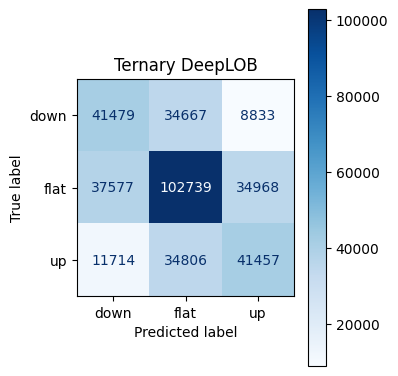

In [87]:
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

probs_t = model_tern.predict(Xte_t_n, batch_size=1024)
y_pred_t = np.argmax(probs_t, axis=1)

print("Ternary DeepLOB – Test report (0=down, 1=flat, 2=up):")
print(
    classification_report(
        yte_t,
        y_pred_t,
        labels=[0,1,2],
        target_names=["down","flat","up"],
        digits=4,
        zero_division=0
    )
)

acc_t = accuracy_score(yte_t, y_pred_t)
f1_macro_t = f1_score(yte_t, y_pred_t, average='macro')

print(f"Accuracy: {acc_t:.4f}, F1_macro: {f1_macro_t:.4f}")

# Confusion matrix
cm_t = confusion_matrix(yte_t, y_pred_t, labels=[0,1,2])
disp_t = ConfusionMatrixDisplay(cm_t, display_labels=["down","flat","up"])
fig, ax = plt.subplots(figsize=(4,4))
disp_t.plot(ax=ax, cmap="Blues", values_format='d')
ax.set_title("Ternary DeepLOB")
plt.tight_layout()
plt.show()


In [88]:
def build_ternary_dataset(df, horizon_steps, threshold, window=20):
    # 1) labels
    mp = df['mid_price'].values
    mp_future = np.roll(mp, -horizon_steps)
    ret = (mp_future - mp) / (mp + 1e-12)
    ret[-horizon_steps:] = np.nan

    labels = np.full(len(df), np.nan)
    up_mask   = ret > threshold
    down_mask = ret < -threshold
    flat_mask = ~(up_mask | down_mask)

    labels[down_mask] = 0
    labels[flat_mask] = 1
    labels[up_mask]   = 2

    df_lab = df.copy()
    df_lab['label_3'] = labels
    df_lab = df_lab.dropna(subset=['label_3']).copy()
    df_lab['label_3'] = df_lab['label_3'].astype(int)

    # 2) sequences
    data = df_lab[feature_cols_sg].values
    lab  = df_lab['label_3'].values

    X, y = [], []
    for i in range(len(df_lab) - window):
        X.append(data[i:i+window])
        y.append(lab[i+window-1])
    X = np.array(X)
    y = np.array(y)

    # 3) split
    N = len(X)
    train_end = int(0.7 * N)
    val_end   = int(0.85 * N)

    X_train, y_train = X[:train_end], y[:train_end]
    X_val,   y_val   = X[train_end:val_end], y[train_end:val_end]
    X_test,  y_test  = X[val_end:], y[val_end:]

    return X_train, y_train, X_val, y_val, X_test, y_test

In [90]:
candidates = []
for horizon in [10, 20, 40]:
    for th in [1e-4, 2e-4, 5e-4]:
        print(f"\n=== horizon={horizon}, threshold={th} ===")
        Xtr, ytr, Xval, yval, Xte, yte = build_ternary_dataset(df_clean, horizon, th, window=20)

        # normalize
        n_features = Xtr.shape[2]
        flat_train = Xtr.reshape(-1, n_features)
        mean = flat_train.mean(axis=0)
        std  = flat_train.std(axis=0) + 1e-8

        def norm(X): return (X - mean) / std
        Xtr_n, Xval_n = norm(Xtr), norm(Xval)

        # tf.data (fewer steps for speed)
        BATCH_SIZE = 512
        train_ds = tf.data.Dataset.from_tensor_slices((Xtr_n, ytr.astype('int32'))).shuffle(100_000).batch(BATCH_SIZE).repeat()
        val_ds   = tf.data.Dataset.from_tensor_slices((Xval_n, yval.astype('int32'))).batch(BATCH_SIZE).repeat()

        model_tmp = build_deeplob_ternary(window=20, n_features=n_features, n_classes=3)
        model_tmp.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(),
            metrics=['accuracy']
        )

        hist = model_tmp.fit(
            train_ds,
            validation_data=val_ds,
            epochs=3,                # quick test
            steps_per_epoch=800,     # smaller
            validation_steps=200,
            verbose=1
        )

        val_acc_last = hist.history['val_accuracy'][-1]
        candidates.append((horizon, th, val_acc_last))
        print(f"VAL_ACC (last epoch) = {val_acc_last:.4f}")

print("\nCandidates (horizon, threshold, val_acc):")
for c in candidates:
    print(c)



=== horizon=10, threshold=0.0001 ===
Epoch 1/3
800/800 ━━━━━━━━━━━━━━━━━━━━ 83s 101ms/step - accuracy: 0.7180 - loss: 0.6694 - val_accuracy: 0.5230 - val_loss: 1.0437
Epoch 2/3
800/800 ━━━━━━━━━━━━━━━━━━━━ 39s 49ms/step - accuracy: 0.5922 - loss: 0.8395 - val_accuracy: 0.6055 - val_loss: 0.8324
Epoch 3/3
800/800 ━━━━━━━━━━━━━━━━━━━━ 26s 33ms/step - accuracy: 0.6100 - loss: 0.8211 - val_accuracy: 0.6134 - val_loss: 0.8133
VAL_ACC (last epoch) = 0.6134

=== horizon=10, threshold=0.0002 ===
Epoch 1/3
800/800 ━━━━━━━━━━━━━━━━━━━━ 29s 34ms/step - accuracy: 0.8942 - loss: 0.3412 - val_accuracy: 0.8267 - val_loss: 0.6251
Epoch 2/3
800/800 ━━━━━━━━━━━━━━━━━━━━ 26s 33ms/step - accuracy: 0.7956 - loss: 0.5454 - val_accuracy: 0.8299 - val_loss: 0.4971
Epoch 3/3
800/800 ━━━━━━━━━━━━━━━━━━━━ 25s 32ms/step - accuracy: 0.8230 - loss: 0.5051 - val_accuracy: 0.8285 - val_loss: 0.4929
VAL_ACC (last epoch) = 0.8285

=== horizon=10, threshold=0.0005 ===
Epoch 1/3
800/800 ━━━━━━━━━━━━━━━━━━━━ 31s 36ms/ste

In [119]:
# GLOBAL CONFIG
WINDOW = 20               # sequence length
HORIZON_STEPS = 10        # <-- chosen
TERN_THRESHOLD = 1e-4     # <-- chosen (0.0005)

feature_cols_sg = [
    'mid_price_sg',
    'spread_sg',
    'bid_depth_sg',
    'ask_depth_sg',
    'obi_sg'
]


In [120]:
import numpy as np
import pandas as pd

def make_ternary_labels(df, horizon=HORIZON_STEPS, threshold=TERN_THRESHOLD):
    mp = df['mid_price'].values
    mp_future = np.roll(mp, -horizon)
    ret = (mp_future - mp) / (mp + 1e-12)

    # last horizon points have no future
    ret[-horizon:] = np.nan

    labels = np.full(len(df), np.nan)

    up_mask   = ret > threshold
    down_mask = ret < -threshold
    flat_mask = ~(up_mask | down_mask)

    labels[down_mask] = 0   # down
    labels[flat_mask] = 1   # flat
    labels[up_mask]   = 2   # up

    return pd.Series(labels, index=df.index, name='label_3')

df_clean['label_3'] = make_ternary_labels(df_clean, HORIZON_STEPS, TERN_THRESHOLD)

print("Label distribution (including NaN):")
print(df_clean['label_3'].value_counts(dropna=False, normalize=True))


Label distribution (including NaN):
label_3
1.0    0.627337
2.0    0.187420
0.0    0.185243
Name: proportion, dtype: float64


In [121]:
df_tern = df_clean.dropna(subset=['label_3']).copy()
df_tern['label_3'] = df_tern['label_3'].astype(int)

print("After dropping NaNs:", df_tern.shape)
print("Final ternary label distribution:")
print(df_tern['label_3'].value_counts(normalize=True))


After dropping NaNs: (2321618, 60)
Final ternary label distribution:
label_3
1    0.627337
2    0.187420
0    0.185243
Name: proportion, dtype: float64


In [122]:
def build_sequences(df, feature_cols, label_col, window):
    data = df[feature_cols].values
    labels = df[label_col].values
    X, y = [], []
    for i in range(len(df) - window):
        X.append(data[i:i+window])
        y.append(labels[i+window-1])
    X = np.array(X)
    y = np.array(y)
    return X, y

X_all_3, y_all_3 = build_sequences(df_tern, feature_cols_sg, 'label_3', WINDOW)
print("X_all_3 shape:", X_all_3.shape, "y_all_3 shape:", y_all_3.shape)
print("Unique labels:", np.unique(y_all_3, return_counts=True))


X_all_3 shape: (2321598, 20, 5) y_all_3 shape: (2321598,)
Unique labels: (array([0, 1, 2]), array([ 430064, 1456416,  435118], dtype=int64))


In [123]:
def time_split_3d(X, y, train_frac=0.7, val_frac=0.15):
    N = len(X)
    train_end = int(N * train_frac)
    val_end   = int(N * (train_frac + val_frac))

    X_train, y_train = X[:train_end], y[:train_end]
    X_val,   y_val   = X[train_end:val_end], y[train_end:val_end]
    X_test,  y_test  = X[val_end:], y[val_end:]
    return X_train, y_train, X_val, y_val, X_test, y_test

Xtr_t, ytr_t, Xval_t, yval_t, Xte_t, yte_t = time_split_3d(X_all_3, y_all_3)

print("Shapes:", Xtr_t.shape, Xval_t.shape, Xte_t.shape)
print("Train labels:", np.unique(ytr_t, return_counts=True))
print("Val labels:",   np.unique(yval_t, return_counts=True))
print("Test labels:",  np.unique(yte_t, return_counts=True))


Shapes: (1625118, 20, 5) (348240, 20, 5) (348240, 20, 5)
Train labels: (array([0, 1, 2]), array([311816, 998283, 315019], dtype=int64))
Val labels: (array([0, 1, 2]), array([ 71652, 205867,  70721], dtype=int64))
Test labels: (array([0, 1, 2]), array([ 46596, 252266,  49378], dtype=int64))


In [124]:
n_features = Xtr_t.shape[2]
flat_train_t = Xtr_t.reshape(-1, n_features)
feat_mean_t = flat_train_t.mean(axis=0)
feat_std_t  = flat_train_t.std(axis=0) + 1e-8

def normalize_sequences(X, mean, std):
    return (X - mean) / std

Xtr_t_n  = normalize_sequences(Xtr_t,  feat_mean_t, feat_std_t)
Xval_t_n = normalize_sequences(Xval_t, feat_mean_t, feat_std_t)
Xte_t_n  = normalize_sequences(Xte_t,  feat_mean_t, feat_std_t)


In [125]:
import tensorflow as tf

ytr_t_i  = ytr_t.astype('int32')
yval_t_i = yval_t.astype('int32')

BATCH_SIZE = 512

train_ds_t = tf.data.Dataset.from_tensor_slices((Xtr_t_n,  ytr_t_i))
val_ds_t   = tf.data.Dataset.from_tensor_slices((Xval_t_n, yval_t_i))

train_ds_t = train_ds_t.shuffle(100_000).batch(BATCH_SIZE).repeat()
val_ds_t   = val_ds_t.batch(BATCH_SIZE).repeat()

# Full-ish steps; you can tweak if too slow
FAST_STEPS = 2000    # ~1M samples / epoch
VAL_STEPS  = 800     # ~256k val samples / epoch

print("Train steps/epoch:", FAST_STEPS, "Val steps:", VAL_STEPS)


Train steps/epoch: 2000 Val steps: 800


In [126]:
from tensorflow.keras import layers, models

window = Xtr_t_n.shape[1]
n_features = Xtr_t_n.shape[2]
n_classes = 3

def build_deeplob_ternary_final(window, n_features, n_classes=3):
    inputs = layers.Input(shape=(window, n_features))
    
    # Block 1
    x = layers.Conv1D(64, 3, padding='causal', activation='relu')(inputs)
    x = layers.Conv1D(64, 3, padding='causal', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(pool_size=2)(x)

    # Block 2
    x = layers.Conv1D(128, 3, padding='causal', activation='relu')(x)
    x = layers.Conv1D(128, 3, padding='causal', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(pool_size=2)(x)

    # LSTM
    x = layers.LSTM(128, return_sequences=False)(x)

    # Dense head
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(n_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model

model_tern = build_deeplob_ternary_final(window, n_features, n_classes)
model_tern.summary()


Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)     │ (None, 20, 5)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_64 (Conv1D)              │ (None, 20, 64)         │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_65 (Conv1D)              │ (None, 20, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 20, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_32 (MaxPooling1D) │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_66 (Conv1D)              │ (None, 10, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_67 (Conv1D)              │ (None, 10, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 10, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_33 (MaxPooling1D) │ (None, 5, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_16 (LSTM)                  │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 236,611 (924.26 KB)

 Trainable params: 236,227 (922.76 KB)

 Non-trainable params: 384 (1.50 KB)

In [130]:
model_tern.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

EPOCHS = 8

callbacks_t = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=3,
        min_lr=1e-5, verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=5,
        restore_best_weights=True, verbose=1
    )
]

history_t = model_tern.fit(
    train_ds_t,
    validation_data=val_ds_t,
    epochs=EPOCHS,
    steps_per_epoch=FAST_STEPS,
    validation_steps=VAL_STEPS,
    callbacks=callbacks_t,
    verbose=1
)


Epoch 1/8
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 252s 125ms/step - accuracy: 0.6421 - loss: 0.7710 - val_accuracy: 0.5889 - val_loss: 0.8469 - learning_rate: 5.0000e-04
Epoch 2/8
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 265s 133ms/step - accuracy: 0.6832 - loss: 0.6937 - val_accuracy: 0.5057 - val_loss: 0.9482 - learning_rate: 5.0000e-04
Epoch 3/8
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 247s 124ms/step - accuracy: 0.6246 - loss: 0.7897 - val_accuracy: 0.6222 - val_loss: 0.7873 - learning_rate: 5.0000e-04
Epoch 4/8
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 91s 46ms/step - accuracy: 0.6819 - loss: 0.6844 - val_accuracy: 0.6089 - val_loss: 0.8036 - learning_rate: 5.0000e-04
Epoch 5/8
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 152s 76ms/step - accuracy: 0.6903 - loss: 0.6752 - val_accuracy: 0.5966 - val_loss: 0.8191 - learning_rate: 5.0000e-04
Epoch 6/8
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 92s 46ms/step - accuracy: 0.6435 - loss: 0.7542 - val_accuracy: 0.6271 - val_loss: 0.7755 - learning_rate: 5.0000e-04
Epoch 7/8
2000/2000 ━━━━━━━━━━━━━━━━━━━

341/341 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step
Ternary DeepLOB FINAL – Test report (0=down,1=flat,2=up):
              precision    recall  f1-score   support

        down     0.4480    0.3495    0.3927     46596
        flat     0.7904    0.8633    0.8252    252266
          up     0.4926    0.3624    0.4176     49378

    accuracy                         0.7236    348240
   macro avg     0.5770    0.5251    0.5452    348240
weighted avg     0.7023    0.7236    0.7096    348240

Test Accuracy: 0.7236, Test Macro-F1: 0.5452


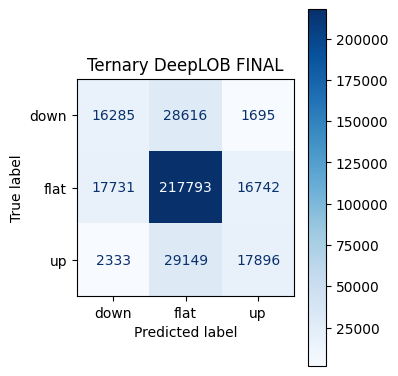

In [132]:
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

probs_t = model_tern.predict(Xte_t_n, batch_size=1024)
y_pred_t = probs_t.argmax(axis=1)

print("Ternary DeepLOB FINAL – Test report (0=down,1=flat,2=up):")
print(
    classification_report(
        yte_t,
        y_pred_t,
        labels=[0,1,2],
        target_names=["down","flat","up"],
        digits=4,
        zero_division=0
    )
)

acc_t = accuracy_score(yte_t, y_pred_t)
f1_macro_t = f1_score(yte_t, y_pred_t, average='macro')
print(f"Test Accuracy: {acc_t:.4f}, Test Macro-F1: {f1_macro_t:.4f}")

cm_t = confusion_matrix(yte_t, y_pred_t, labels=[0,1,2])
disp_t = ConfusionMatrixDisplay(cm_t, display_labels=["down","flat","up"])
fig, ax = plt.subplots(figsize=(4,4))
disp_t.plot(ax=ax, cmap="Blues", values_format='d')
ax.set_title("Ternary DeepLOB FINAL")
plt.tight_layout()
plt.show()


In [133]:
import numpy as np

# Probabilities and class predictions for test set
probs_t = model_tern.predict(Xte_t_n, batch_size=1024)
y_pred_t = probs_t.argmax(axis=1)

# Also store max confidence per sample (for optional filters later)
conf_max = probs_t.max(axis=1)

print("Test preds shape:", y_pred_t.shape)
print("Conf range:", conf_max.min(), "→", conf_max.max())


341/341 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step
Test preds shape: (348240,)
Conf range: 0.334988 → 0.9995803


In [134]:
# Global sequence indices for test chunk
N_seq = X_all_3.shape[0]
train_end = int(N_seq * 0.7)
val_end   = int(N_seq * 0.85)
test_start_seq = val_end

seq_idx_global = test_start_seq + np.arange(len(y_pred_t))

WINDOW = 20         # your sequence length
HORIZON_STEPS = 10  # your chosen horizon

mid = df_tern['mid_price'].values

# Index in df_tern where we enter the trade (last step of window)
idx_now    = seq_idx_global + (WINDOW - 1)
idx_future = idx_now + HORIZON_STEPS

# Drop predictions whose future index runs off the end
valid_mask = idx_future < len(mid)
idx_now    = idx_now[valid_mask]
idx_future = idx_future[valid_mask]
y_pred_bt  = y_pred_t[valid_mask]
conf_bt    = conf_max[valid_mask]

mid_now    = mid[idx_now]
mid_future = mid[idx_future]

# Realized return over the horizon
ret = (mid_future - mid_now) / mid_now
print("ret stats:", ret.min(), ret.max(), ret.mean())
print("Number of usable test samples:", len(ret))


ret stats: -0.001756145909262587 0.0016824662130628216 8.709668844033063e-07
Number of usable test samples: 348231


In [135]:
# Map class to position: 2=up->+1, 0=down->-1, 1=flat->0
position_raw = np.where(y_pred_bt == 2,  1,
                 np.where(y_pred_bt == 0, -1, 0))

# OPTIONAL: only trade when model is confident (say ≥ 0.6)
alpha = 0.6  # you can experiment with 0.5, 0.7, etc.
trade_mask_conf = conf_bt >= alpha

position = np.where(trade_mask_conf, position_raw, 0)

print("Unique positions:", np.unique(position, return_counts=True))


Unique positions: (array([-1,  0,  1]), array([ 16060, 316472,  15699], dtype=int64))


In [149]:
import matplotlib.pyplot as plt

cost_per_side   = 0.00002
roundtrip_cost  = 2 * cost_per_side

trade_flag = (position != 0).astype(int)

gross_pnl = position * ret            # return from price move
net_pnl   = gross_pnl - roundtrip_cost * trade_flag

equity_curve = (1 + net_pnl).cumprod()


Number of trades: 31759
Total net return: 11.95584732657571
Hit rate (profit trades %): 0.8420920054157877
Sharpe-like ratio: 0.17175243465964032


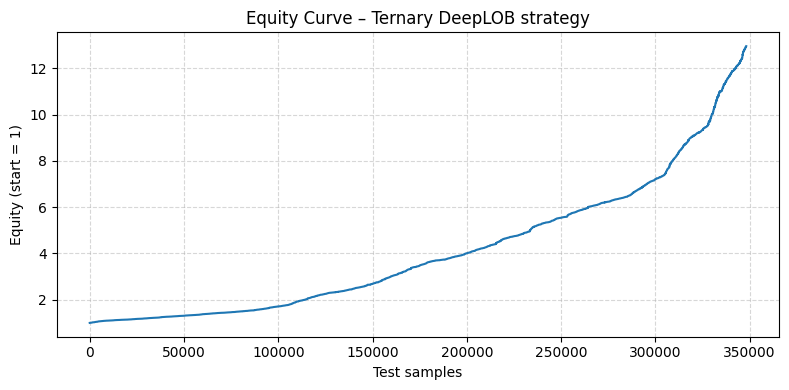

In [150]:
from math import sqrt

print("Number of trades:", trade_flag.sum())
print("Total net return:", equity_curve[-1] - 1)

if trade_flag.sum() > 0:
    trade_pnls = net_pnl[trade_flag == 1]
    print("Hit rate (profit trades %):", (trade_pnls > 0).mean())

# Simple Sharpe-like ratio (per-step, not annualised)
if net_pnl.std() > 0:
    sharpe = net_pnl.mean() / net_pnl.std()
    print("Sharpe-like ratio:", sharpe)

plt.figure(figsize=(8,4))
plt.plot(equity_curve)
plt.title("Equity Curve – Ternary DeepLOB strategy")
plt.xlabel("Test samples")
plt.ylabel("Equity (start = 1)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
